In [1]:
import sys
print(sys.version)
import numpy as np
import ROOT
from array import *
import matplotlib.pyplot as plt
import math
from scipy.optimize import brentq

3.12.3 (main, Apr 10 2024, 05:33:47) [GCC 13.2.0]


In [2]:
def resultsTOtxt(arr,  filename):
#arr is the concatenated and transposed array of all the arrays wished to be written
#arrDescription a string describing and is each collumn of the file
#writes out each array concatenated in arr as an collumn in the file
    file = open(filename, 'w')
    np.savetxt(filename, arr, delimiter=' ')
    file.close()

In [3]:
listsamples = ['m05_b1p1', 'm05_b1p5', 'm05_b10', 'm10_b1p1', 'm10_b1p5', 'm10_b10', 'm20_b1p1', 'm20_b1p5', 'm20_b10', 'm40_b1p1', 'm40_b1p5', 'm40_b10']
list_samples_latex = [r'$m_\chi = 5 \text{ GeV}, \; \gamma=1.1$', r'$m_\chi = 10 \text{ GeV}, \; \gamma=1.1$',r'$m_\chi = 20 \text{ GeV}, \; \gamma=1.1$', r'$m_\chi = 40 \text{ GeV}, \; \gamma=1.1$', r'$m_\chi = 5 \text{ GeV}, \; \gamma=1.5$', r'$m_\chi = 10 \text{ GeV}, \; \gamma=1.5$', r'$m_\chi = 20 \text{ GeV}, \; \gamma=1.5$', r'$m_\chi = 40 \text{ GeV}, \; \gamma=1.5$', r'$m_\chi = 5 \text{ GeV}, \; \gamma=10$', r'$m_\chi = 10 \text{ GeV}, \; \gamma=10$', r'$m_\chi = 20 \text{ GeV}, \; \gamma=10$', r'$m_\chi = 40 \text{ GeV}, \; \gamma=10$' ]


In [4]:
def ReadNuclearModelSamples():
    fatm_hA_BR = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/atm_hA_BR.root')
    fbdm_m05_b1p1 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m05_b1p1_00a.root') 
    fbdm_m10_b1p1 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m10_b1p1_00a.root')
    fbdm_m20_b1p1 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m20_b1p1_00a.root')  
    fbdm_m40_b1p1 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m40_b1p1_00a.root')
    fbdm_m05_b1p5 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m05_b1p5_00a.root')  
    fbdm_m10_b1p5 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m10_b1p5_00a.root')
    fbdm_m20_b1p5 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m20_b1p5_00a.root')
    fbdm_m40_b1p5 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m40_b1p5_00a.root')
    fbdm_m05_b10 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m05_b10_00a.root')     
    fbdm_m10_b10 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m10_b10_00a.root')
    fbdm_m20_b10 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m20_b10_00a.root')
    fbdm_m40_b10 = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_m40_b10_00a.root')
    samples = [fatm_hA_BR, fbdm_m05_b1p1, fbdm_m10_b1p1, fbdm_m20_b1p1, fbdm_m40_b1p1, fbdm_m05_b1p5, fbdm_m10_b1p5, fbdm_m20_b1p5, fbdm_m40_b1p5, fbdm_m05_b10, fbdm_m10_b10, fbdm_m20_b10, fbdm_m40_b10]
    return samples


In [5]:
def GetNpArraysFromTrees(tree, branch_name):
    estimate = 3e6 #amount of numbers getting from branch
    tree.SetEstimate(int(estimate))
    result_hist = tree.Draw(branch_name, "", "goff")
    result = np.asarray(np.frombuffer(tree.GetV1(), dtype=np.float64, count=result_hist))
    result = result.copy()
    return result
def GetNpArraysFromTrees2(tree, branch_name):
    estimate = 3e8 #amount of numbers getting from branch
    tree.SetEstimate(int(estimate))
    result_hist = tree.Draw(branch_name, "", "goff")
    result = np.asarray(np.frombuffer(tree.GetV1(), count=result_hist))
    result = result.copy()
    return result

In [6]:
def CVNCut(CVN_CutProb,CVN_SignalReco,CVN_Bg,CosSun_SignalValidCVN,AtmNuCosSun):
    nSignalEvents = 0 
    nBGEvents = 0
    EventsSignalCut = CVN_SignalReco[CVN_SignalReco > CVN_CutProb]
    EventsBgCut = CVN_Bg[CVN_Bg > CVN_CutProb] 
    CosSunSignal_CVNCut = CosSun_SignalValidCVN[CVN_SignalReco > CVN_CutProb]
    CosSunBgCVNCut = AtmNuCosSun[CVN_Bg > CVN_CutProb]
    return CosSunSignal_CVNCut, CosSunBgCVNCut, EventsSignalCut, EventsBgCut

In [7]:
def AngularCutBothSides(CVNScore_NC, nSignalSimulatedEvts): 
    
    results = []
    SprimeMin = 999999999
    bestCutRight = 9999
    bestCutLeft = 9999
    bestEff = 9999
    bestBkg = 9999
    bestBkgErr = 999
    Sprime = 999
    CosSunSignal = []
    CosSunAtm = []
    
    CosSunSignalCVNCut, CosSunBgCVNCut, SignalEvts, BgEvts = CVNCut(CVNScore_NC, CVN_Signal, CVN_Atm, CosSun_Signal, CosSun_Atm)
    
    BackgroundScale = 4 * 10 * RatioRecoAtm *2235.8 /nSimulatedEvtsAll_atm
    # = 40kt * 10 years * reco/simulated ratio * # atm nu expected for 10kt y * inside/out cvn cut ratio / #simulated atm nu events 

    CosCutsToRight = np.linspace(0.5,1.00,40)
    CosCutsToLeft = np.linspace(0.5,-1.00,40)
    
    CosSunEvts = CosSunSignalCVNCut
    CosSunAtmEvts = CosSunBgCVNCut
    for CosCutRight in CosCutsToRight:

        for CosCutLeft in CosCutsToLeft:
            nReco = 0.0001
            nBG = 0.00001
            nRecoToTheRight = np.sum(CosCutRight < CosSunEvts)
            nRecoToTheLeft = np.sum(CosCutLeft > CosSunEvts)
            nReco = nRecoToTheRight + nRecoToTheLeft
            
            nBGToTheRight = np.sum(CosCutRight < CosSunAtmEvts)
            nBGToTheLeft = np.sum(CosCutLeft > CosSunAtmEvts)
            nBG = nBGToTheRight + nBGToTheLeft
            
            rReco = nReco/nSignalSimulatedEvts  
            bEvents = nBG*BackgroundScale
            
            #print(rReco,nReco,nSignalSimulatedEvts)
            Sprime = 25./ (2.*rReco) + math.sqrt( 25.*bEvents/ (rReco*rReco) + 625./(4.*rReco*rReco) )
            
            if Sprime < SprimeMin:
                SprimeMin = Sprime
                bestCutRight = CosCutRight
                bestCutLeft = CosCutLeft
                bestEff = rReco
                bestBkg = bEvents
                bestBkgErr = math.sqrt(nBG *BackgroundScale)
                BestCVNCut = CVNScore_NC
                CosSunSignal = CosSunEvts
                CosSunAtm = CosSunAtmEvts
    results = [SprimeMin, bestCutLeft, bestCutRight, bestEff, bestBkg, bestBkgErr, CVNScore_NC, CosSunEvts, CosSunAtmEvts]
    return results

In [8]:
infiles_list = ReadNuclearModelSamples()
for SAMPLE_INDEX in range(0,len(infiles_list)):
    intrees_reco = [lambda arg=infile: arg.Get("ana/Atm") for infile in infiles_list]
    intrees_simu = [lambda arg=infile: arg.Get("ana/AllEvents") for infile in infiles_list]
    reco_entries = [intree().GetEntries() for intree in intrees_reco]
    simu_entries = [intree().GetEntries() for intree in intrees_simu]

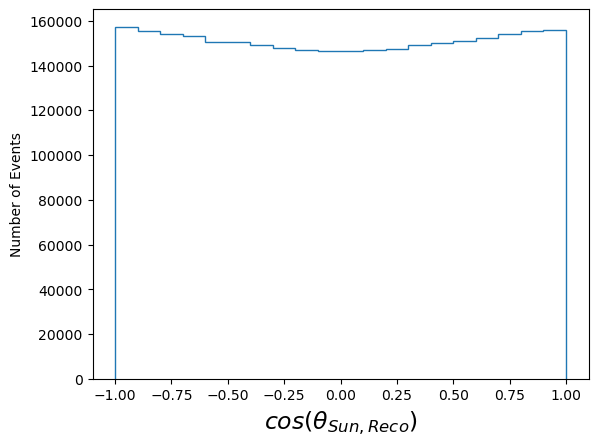

In [9]:
### Atmospheric neutrinos Angular Reconstruction w.r.t Sun
TotalMomRecoRangeUnitVect_Reco = GetNpArraysFromTrees2(intrees_reco[0]()," TotalMomRecoRangeUnitVect")
nSimulatedEvtsReco_atm = reco_entries[0]
Reco_mom_Nu = np.reshape(TotalMomRecoRangeUnitVect_Reco, (nSimulatedEvtsReco_atm,3))
Sun_Positions = np.loadtxt('../../newSyst/background_sun_pos.dat', delimiter='\t', usecols=(0,1,2))

hist_cos_reco = []
for index, atmevt in enumerate(Reco_mom_Nu):
    indices = np.random.randint(0, len(Sun_Positions), size=1)
    # Use the sampled indices to select elements from the array
    sample_sunpos = Sun_Positions[indices]
    for sunpos in sample_sunpos:
        hist_cos_reco.append(np.sum(atmevt*sunpos))

plt.figure(dpi=100)
plt.hist(hist_cos_reco, bins = 20,histtype = 'step')
#plt.title(f'index number evt: {index}')
plt.ylabel('Number of Events')
plt.xlabel(r'$cos(\theta_{Sun, Reco})$',fontsize = 17)
plt.show()


In [10]:
nSimulatedEvtsAll_atm = simu_entries[0]
RatioRecoAtm = nSimulatedEvtsReco_atm/nSimulatedEvtsAll_atm

CVN_Atm = GetNpArraysFromTrees(intrees_reco[0](),"CVN_NCScore")
CosSun_Atm = np.array(hist_cos_reco)
CVN_Atm[CVN_Atm==-1] = 1.


Sensitivity_Info = open("OptimalCuts/CVNandAng/Sensitivity_Info_00a.txt", "a")
Sensitivity_results = open("OptimalCuts/CVNandAng/Sensitivity_results_00a.txt","a")
Eff_Bkg_index =open("OptimalCuts/CVNandAng/Eff_Bkg_index_00a.txt","a")
CVN_Cuts = np.linspace(0.2,1.00,70)

Sensitivity_Info.write("################# SAMPLE INFO #######################"+"\n")
Sensitivity_Info.write("\n")
Sensitivity_Info.write("Number of Atmospheric Neutrinos Events Simulated: " +str(nSimulatedEvtsAll_atm)+"\n")
Sensitivity_Info.write("Number of Atmospheric Neutrinos Events Reconstructed: " +str(nSimulatedEvtsReco_atm)+"\n")
Sensitivity_Info.write("Ratio of Atmospheric Neutrinos Events Reconstructed: " +str(nSimulatedEvtsReco_atm/nSimulatedEvtsAll_atm)+"\n")
Sensitivity_Info.write("\n")

resultsTOtxt(CVN_Atm, 'OptimalCuts/CVNandAng/CVN_Atm_hA_BR.txt')
resultsTOtxt(CosSun_Atm, 'OptimalCuts/CVNandAng/CosSun_Atm_hA_BR.txt')

Eff_Bkg_index.write("SigStrength\tNegCosCut\tPosCosCut\tbestEff\tBkgExpect\tBkgError\tCVNCut\n")


66

In [11]:
for index, sig_tree in enumerate(intrees_reco[1:]):
    print(sig_tree())
    print(index)
    
    CVN_Signal = GetNpArraysFromTrees(sig_tree(),"CVN_NCScore")
    CVN_Signal[CVN_Signal==-1] = 1.

    CosSun_Signal = GetNpArraysFromTrees(sig_tree(),"DiffCosAngleTotalMom")
    
    bestResultsTwoAngCuts = []
    SpMinTwoAngCuts = 99999999.9
    bestCVNCutTwoCut = -3

    Sensitivity_Info.write("Sample: "+str(sig_tree().GetCurrentFile().GetName()[28:-5])+"\n")
    Sensitivity_Info.write("Number of Boosted DM Events Simulated: " +str(simu_entries[index+1])+"\n")
    Sensitivity_Info.write("Number of Boosted DM Events Reconstructed: " + str(reco_entries[index+1])+"\n")
    Sensitivity_Info.write("Ratio of Boosted DM Events Reconstructed: " +str(float(reco_entries[index+1])/simu_entries[index+1])+"\n")
    Sensitivity_Info.write("\n")

    Sensitivity_results.write("Sample: "+str(sig_tree().GetCurrentFile().GetName()[28:-5])+"\n")
    Sensitivity_results.write("SigStrength\tNegCosCut\tPosCosCut\tbestEff\tBkgExpect\tBkgError\tCVNCut\tBDTCut\n")
    for CVNScore in CVN_Cuts:
        resultsTwoAngCuts = AngularCutBothSides(CVNScore, simu_entries[index+1])
        if resultsTwoAngCuts[0] < SpMinTwoAngCuts:
            bestResultsTwoAngCuts = resultsTwoAngCuts
            bestCVNCutTwoCut = CVNScore
            SpMinTwoAngCuts = resultsTwoAngCuts[0]
                
            Sensitivity_results.write(str(bestResultsTwoAngCuts[0])+"\t"+str(bestResultsTwoAngCuts[1])+"\t"+str(bestResultsTwoAngCuts[2])+"\t"+str(bestResultsTwoAngCuts[3])+"\t"+str(bestResultsTwoAngCuts[4])+"\t"+str(bestResultsTwoAngCuts[5])+"\t"+str(bestResultsTwoAngCuts[6])+"\n")
                

    Sensitivity_results.write(str(" ======= BEST CUTS ========")+"\n")
    Sensitivity_results.write(str(bestResultsTwoAngCuts[0])+"\t"+str(bestResultsTwoAngCuts[1])+"\t"+str(bestResultsTwoAngCuts[2])+"\t"+str(bestResultsTwoAngCuts[3])+"\t"+str(bestResultsTwoAngCuts[4])+"\t"+str(bestResultsTwoAngCuts[5])+"\t"+str(bestResultsTwoAngCuts[6])+"\n")   
    np.savetxt(Eff_Bkg_index, np.array(bestResultsTwoAngCuts[0:7]).flatten(), fmt="%.3f", newline = " ",delimiter=', ')
    Eff_Bkg_index.write("\n")
    Sensitivity_results.write("\n")
    print('\n')
    print(index)
    print("################# BEST ANGULAR AND CVN CUTS INFO #######################")
    print("Optimal Signal Strength: " + '{:.0f}'.format(bestResultsTwoAngCuts[0]))
    print("Optimal CVN Cut: " +'{:.3f}'.format(bestResultsTwoAngCuts[6]))
    print("Optimal Positive Cossine Angular Cut: "  + '{:.3f}'.format(bestResultsTwoAngCuts[2]))
    print("Optimal Negative Cossine Angular Cut: " +  '{:.3f}'.format(bestResultsTwoAngCuts[1]))
    print("Signal Efficiency: " + '{:.3f}'.format(bestResultsTwoAngCuts[3]))
    print("")
    print("Number of expected Atm Nu events: " + '{:.1f}'.format(bestResultsTwoAngCuts[4]) + ", statistical uncertainty: " + '{:.1f}'.format(bestResultsTwoAngCuts[5]))
    print('\n')
    #h.write('{:.3f}'.format(bestResultsTwoAngCuts[3]),'{:.3f}'.format(bestResultsTwoAngCuts[4]),'{:.1d}'.format(index))
   
    resultsTOtxt(bestResultsTwoAngCuts[7], 'OptimalCuts/CVNandAng/CosSunSignalAfterCuts_'+listsamples[index]+'.txt')
    resultsTOtxt(bestResultsTwoAngCuts[8], 'OptimalCuts/CVNandAng/CosSunAtmAfterCuts_'+listsamples[index]+'.txt')
    resultsTOtxt(CVN_Signal, 'OptimalCuts/CVNandAng/CVN_'+listsamples[index]+'.txt')
    resultsTOtxt(CosSun_Signal, 'OptimalCuts/CVNandAng/CosSun_'+listsamples[index]+'.txt')

Name: Atm Title: AtmosphericAnalysis
0


/tmp/ipykernel_5565/2213536758.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  Sprime = 25./ (2.*rReco) + math.sqrt( 25.*bEvents/ (rReco*rReco) + 625./(4.*rReco*rReco) )
/tmp/ipykernel_5565/2213536758.py:41: RuntimeWarning: invalid value encountered in scalar divide
  Sprime = 25./ (2.*rReco) + math.sqrt( 25.*bEvents/ (rReco*rReco) + 625./(4.*rReco*rReco) )




0
################# BEST ANGULAR AND CVN CUTS INFO #######################
Optimal Signal Strength: 252264
Optimal CVN Cut: 0.992
Optimal Positive Cossine Angular Cut: 0.500
Optimal Negative Cossine Angular Cut: 0.500
Signal Efficiency: 0.002

Number of expected Atm Nu events: 8140.2, statistical uncertainty: 90.2


Name: Atm Title: AtmosphericAnalysis
1


1
################# BEST ANGULAR AND CVN CUTS INFO #######################
Optimal Signal Strength: 5065
Optimal CVN Cut: 0.992
Optimal Positive Cossine Angular Cut: 0.500
Optimal Negative Cossine Angular Cut: 0.500
Signal Efficiency: 0.092

Number of expected Atm Nu events: 8140.2, statistical uncertainty: 90.2


Name: Atm Title: AtmosphericAnalysis
2


2
################# BEST ANGULAR AND CVN CUTS INFO #######################
Optimal Signal Strength: 4789
Optimal CVN Cut: 0.992
Optimal Positive Cossine Angular Cut: 0.500
Optimal Negative Cossine Angular Cut: 0.500
Signal Efficiency: 0.097

Number of expected Atm Nu events: 8140.2

In [12]:
Sensitivity_Info.close()
Sensitivity_results.close()
Eff_Bkg_index.close()